# Twitter Sentiment Analysis no Geo Location

General climate change sentiment of tweets in english, searching for the terms:

- climate change
- global warming
- climate hoax

Timeframe: 2021-04-30 to 2021-05-17

Tweets: 108.293

**Importing libraries**

In [1]:
#Data Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Text Processing
#nltk.download('punkt')
#nltk.download('wordnet')
import spacy
import re
import nltk
from nltk.tokenize import TweetTokenizer
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from emoji import UNICODE_EMOJI

**Importing data**

In [2]:
df = pd.read_csv('../Data/tweets_nogeo.csv', index_col=0)

In [3]:
df.head(3)

,id,date,content,coordinates,place,user
0,1394326695260393473,2021-05-17 16:19:24+00:00,"It was a beautiful visit to Coton Manor, in No...",NaN,NaN,"{'username': 'fransherbourne', 'displayname': ..."
1,1394326567174672391,2021-05-17 16:18:53+00:00,A 🇺🇸 U.S. map heating up from 1991 to 2020.\n\...,NaN,NaN,"{'username': 'Jean_Is_fed_up', 'displayname': ..."
2,1394326500804120581,2021-05-17 16:18:37+00:00,#HedgeAZ\nN is for NEW hedges! \nSo much to sa...,NaN,NaN,"{'username': 'FavColour_Green', 'displayname':..."


In [4]:
len(df)

108293

In [5]:
df['content'][2]

'#HedgeAZ\nN is for NEW hedges! \nSo much to say– possibly another rollercoaster\n\nHedges offer us some really easy wins against the double threats of biodiversity &amp; climate change awfulness. So planting new hedges is quite rightly at the top of a number of agendas. (Including mine) https://t.co/OAgC3i9uBP'

**Cleaning text**

In [17]:
def tweet_preprocessing(tweet):
    
    '''
    This functions cleans tweets from line breaks, URLs, Numbers,...
    '''
    
    tweet = tweet.lower() #to lower case
    tweet = tweet.replace('\n', ' ') # remove line breaks
    tweet = tweet.replace('\@(\w*)', '') # remove mentions
    tweet = re.sub(r"\bhttps://t.co/\w+", '', tweet) # remove URLs
    tweet = re.sub('\w*\d\w*', '', tweet) # remove numbers
    tweet = re.sub(r'\#', '', tweet) # remove hashtags. To remove full hashtag: '\#(\w*)'
    tweet = re.sub('\w*\d\w*', '', tweet) # removes numbers?
    tweet = re.sub(' +', ' ', tweet) # remove 1+ spaces

    return tweet

In [18]:
def strip_emoji(text):
    
    '''
    This function removes any emojis
    '''
    
    RE_EMOJI = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
    return RE_EMOJI.sub(r'', text)

In [19]:
#applying functions to clean tweets
df['content_clean'] = df['content'].apply(tweet_preprocessing)
df['content_clean'] = df['content_clean'].apply(strip_emoji)

In [20]:
#Tokanizing tweets
tt = TweetTokenizer()
df['content_clean'] = df['content_clean'].apply(tt.tokenize)

In [21]:
#Cleaning tokens
df['content_clean'] = df['content_clean'].apply(lambda x: " ".join(x for x in x if re.match(r'[^\W\d]*$', x)))

In [22]:
# Lemmatizing

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

df['content_clean'] = df['content_clean'].apply(lemmatize_text)

In [23]:
df['content_clean'][10]

['another',
 'banger',
 'from',
 'freddie',
 'deboer',
 'trying',
 'to',
 'fight',
 'educational',
 'inequality',
 'by',
 'getting',
 'rid',
 'of',
 'the',
 'sat',
 'is',
 'like',
 'trying',
 'to',
 'fight',
 'climate',
 'change',
 'by',
 'getting',
 'rid',
 'of',
 'thermometer']

In [24]:
#Removing stop words
stop = stopwords.words('english')
df['content_clean'] = df['content_clean'].apply(lambda x: " ".join(x for x in x if x not in stop))

In [ ]:
#Removing words that are negative but not negative in the climate setting
to_remove = ['fight', 'fighting', 'crisis', 'threat', 'threaten']

df['content_clean'] = df['content_clean'].apply(lambda x: " ".join(x for x in x.split() if x not in to_remove))

In [25]:
df['content_clean'][10]

'another banger freddie deboer trying fight educational inequality getting rid sat like trying fight climate change getting rid thermometer'

In [26]:
#Removing words that are negative but not negative in the climate setting
to_remove = ['fight', 'fighting', 'crisis']

df['content_clean'] = df['content_clean'].apply(lambda x: " ".join(x for x in x.split() if x not in to_remove))

In [27]:
#Final cleaned tweet
df['content_clean'][10]

'another banger freddie deboer trying educational inequality getting rid sat like trying climate change getting rid thermometer'

**Predicting Sentiment**

In [28]:
#sentiment with vader
analyzer = SentimentIntensityAnalyzer()

scores = []
compound_list = []
positive_list = []
negative_list = []
neutral_list = []

for i in range(df['content_clean'].shape[0]):
    compound = analyzer.polarity_scores(df['content_clean'][i])["compound"]
    pos = analyzer.polarity_scores(df['content_clean'][i])["pos"]
    neu = analyzer.polarity_scores(df['content_clean'][i])["neu"]
    neg = analyzer.polarity_scores(df['content_clean'][i])["neg"]
    
    scores.append({"comp": compound,
                       "positive": pos,
                       "negative": neg,
                       "neutral": neu
                  })
    
sentiments_score = pd.DataFrame.from_dict(scores)
df = df.join(sentiments_score)

In [29]:
df.head(3)

,id,date,content,coordinates,place,user,content_clean,comp,positive,negative,neutral
0,1394326695260393473,2021-05-17 16:19:24+00:00,"It was a beautiful visit to Coton Manor, in No...",NaN,NaN,"{'username': 'fransherbourne', 'displayname': ...",wa beautiful visit coton manor northamptonshir...,0.6808,0.215,0.087,0.698
1,1394326567174672391,2021-05-17 16:18:53+00:00,A 🇺🇸 U.S. map heating up from 1991 to 2020.\n\...,NaN,NaN,"{'username': 'Jean_Is_fed_up', 'displayname': ...",u map heating global warming real thing know c...,0.4767,0.227,0.000,0.773
2,1394326500804120581,2021-05-17 16:18:37+00:00,#HedgeAZ\nN is for NEW hedges! \nSo much to sa...,NaN,NaN,"{'username': 'FavColour_Green', 'displayname':...",hedgeaz n new hedge much say possibly another ...,0.7589,0.271,0.084,0.645


<AxesSubplot:xlabel='positive'>

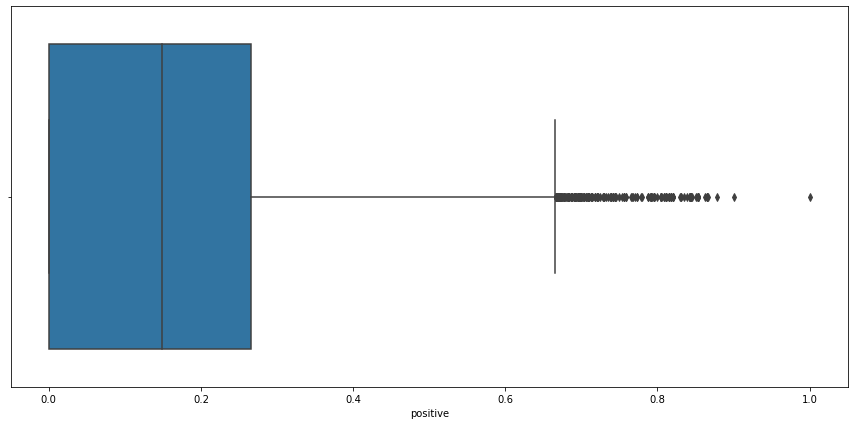

In [16]:
#distribution of polarity
plt.figure(figsize=(15, 7))
sns.boxplot(x = df['positive'])

<AxesSubplot:xlabel='negative'>

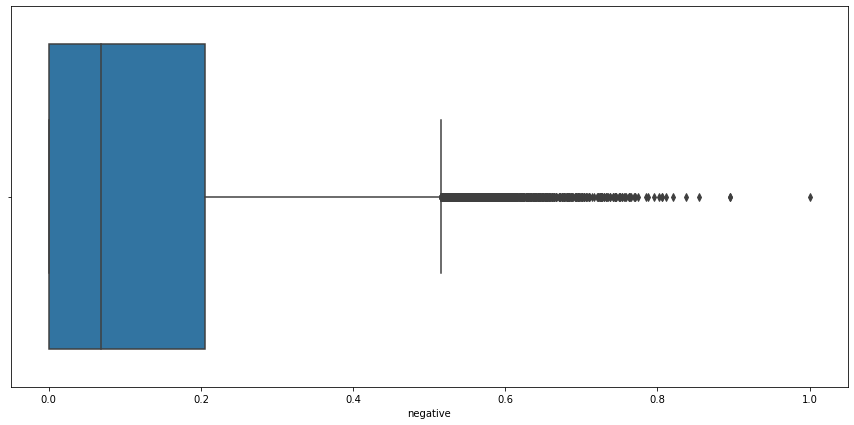

In [17]:
plt.figure(figsize=(15, 7))
sns.boxplot(x = df['negative'])

In [30]:
#Creating column with sentiment description
df['sentiment'] = np.where(df['comp'] > 0.1, 'positive', (np.where(df['comp'] < -0.1, 'negative', 'neutral')))

In [31]:
#Getting number of values in each category
sentiment_dist = df['sentiment'].value_counts().to_frame().reset_index().rename(columns={'index': 'sentiment', 'sentiment': 'count'})
sentiment_dist

,sentiment,count
0,positive,53626
1,negative,30953
2,neutral,23714


<AxesSubplot:xlabel='sentiment', ylabel='count'>

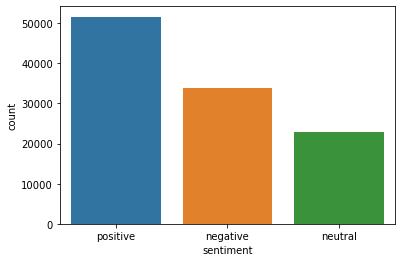

In [26]:
sns.barplot(x=sentiment_dist['sentiment'], y=sentiment_dist['count'])

In [33]:
df[df['sentiment'] == 'negative'].head(10)

,id,date,content,coordinates,place,user,content_clean,comp,positive,negative,neutral,sentiment
3,1394326465567543297,2021-05-17 16:18:29+00:00,"By @amywestervelt: ""Big Oil Is Trying to Make ...",NaN,NaN,"{'username': 'StopMoneyPipe', 'displayname': '...",big oil trying make climate change problem sol...,-0.2263,0.144,0.216,0.640,negative
6,1394326370692616193,2021-05-17 16:18:06+00:00,Climate change optimism should be dead. Show u...,NaN,NaN,"{'username': 'Spencer_Berg_', 'displayname': '...",climate change optimism dead show blow bitch,-0.6808,0.224,0.519,0.256,negative
11,1394326159408594948,2021-05-17 16:17:16+00:00,"Of all the stupidest wastes of money, #sacrame...",NaN,NaN,"{'username': 'Soldier4_Truth', 'displayname': ...",stupidest waste money sacramentocapitolseconne...,-0.8442,0.000,0.394,0.606,negative
23,1394325580884099072,2021-05-17 16:14:58+00:00,The problem is that to a large % of people in ...,NaN,NaN,"{'username': 'JunagarhMedia', 'displayname': '...",problem large people life bubble mean nothing ...,-0.6527,0.079,0.236,0.685,negative
28,1394325404643696646,2021-05-17 16:14:16+00:00,Wouldn’t it be cool if the money the governmen...,NaN,NaN,"{'username': 'samantha_smith2', 'displayname':...",cool money government sends country commit war...,-0.1541,0.261,0.275,0.464,negative
33,1394325035171696642,2021-05-17 16:12:48+00:00,There's an effort to treat climate change as a...,NaN,NaN,"{'username': 'DavidGriscom', 'displayname': 'D...",effort treat climate change purely scientific ...,-0.5523,0.202,0.366,0.432,negative
34,1394325001067630593,2021-05-17 16:12:40+00:00,ARE YOU TELLING ME FUCKING CLIMATE CHANGE IS W...,NaN,NaN,"{'username': 'hellostarshine_', 'displayname':...",telling fucking climate change im itchy hurt,-0.6705,0.000,0.524,0.476,negative
37,1394324909979885573,2021-05-17 16:12:18+00:00,"WAIT FROM THE FAR LEFT GLOBAL WARMING ""CONSPIR...",NaN,NaN,"{'username': 'VeganFemanistic', 'displayname':...",wait far left global warming conspiracy,-0.4215,0.178,0.378,0.444,negative
41,1394324731860553728,2021-05-17 16:11:36+00:00,How climate change is making already bad aller...,NaN,NaN,"{'username': 'ecobearwitness', 'displayname': ...",climate change making already bad allergy seas...,-0.7650,0.000,0.375,0.625,negative
44,1394324644333641731,2021-05-17 16:11:15+00:00,this was the photo that prompted widespread di...,NaN,NaN,"{'username': 'atzrifle', 'displayname': 'risa'...",wa photo prompted widespread discourse global ...,-0.1779,0.214,0.198,0.588,negative


In [22]:
#getting positve hashtags
HT_positive = []

def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
    return hashtags
# extracting hashtags from positive tweetsHT_positive = hashtag_extract(df_tws['text'][df_tws['sent'] == 1])
# extracting hashtags from  tweets
HT_positive = hashtag_extract(df['content'][df['comp'] > 0.5])
# unnesting list
HT_positive = sum(HT_positive,[])
HT_positive

['HedgeAZ',
 'PR',
 'PRREQUEST',
 'journorequest',
 'journorequests',
 'ECO',
 'PRIZE',
 'press',
 'goodybag',
 'giveaway',
 'competition',
 'missenhland',
 'award',
 'ecohamper',
 'climatechange',
 'changemaker',
 'BTC',
 'GlobalWarming',
 'Crypto',
 'ClimateChange',
 'PeakDistrict',
 'technology',
 'onpoli',
 'torontostar',
 'innovation',
 'ClimateChange',
 'NowReading',
 'ClimateAction',
 'RaceToZero',
 'environmentaljustice',
 'climatechange',
 'solar',
 'ClimateAssembly',
 'TresederForIrvine',
 'LossandDamage',
 'COP26',
 'FastStartFinance',
 'ClimateChange',
 'FridaysForFuture',
 'Berlin',
 'ClimateChange',
 'cinemastrikesback',
 'Influencer',
 'BlackLivesMatter',
 'ForaFutureDancefloor',
 'EndSARS',
 'climatechange',
 'globalwarming',
 'nwo',
 'agenda2030',
 'CORiver',
 'infrastructure',
 'resilience',
 'climate',
 'energyefficiency',
 'foodsystems',
 'ClimateChange',
 'Forcast',
 'ClimateRefugees',
 'ClimateChange',
 'transboundary',
 'adaptation',
 'Asia',
 'ClimateAction',
 '

In [34]:
#Saving data
df.to_csv('../Data/sentiments_nogeo.csv')

In [35]:
df

,id,date,content,coordinates,place,user,content_clean,comp,positive,negative,neutral,sentiment
0,1394326695260393473,2021-05-17 16:19:24+00:00,"It was a beautiful visit to Coton Manor, in No...",NaN,NaN,"{'username': 'fransherbourne', 'displayname': ...",wa beautiful visit coton manor northamptonshir...,0.6808,0.215,0.087,0.698,positive
1,1394326567174672391,2021-05-17 16:18:53+00:00,A 🇺🇸 U.S. map heating up from 1991 to 2020.\n\...,NaN,NaN,"{'username': 'Jean_Is_fed_up', 'displayname': ...",u map heating global warming real thing know c...,0.4767,0.227,0.000,0.773,positive
2,1394326500804120581,2021-05-17 16:18:37+00:00,#HedgeAZ\nN is for NEW hedges! \nSo much to sa...,NaN,NaN,"{'username': 'FavColour_Green', 'displayname':...",hedgeaz n new hedge much say possibly another ...,0.7589,0.271,0.084,0.645,positive
3,1394326465567543297,2021-05-17 16:18:29+00:00,"By @amywestervelt: ""Big Oil Is Trying to Make ...",NaN,NaN,"{'username': 'StopMoneyPipe', 'displayname': '...",big oil trying make climate change problem sol...,-0.2263,0.144,0.216,0.640,negative
4,1394326458042961922,2021-05-17 16:18:27+00:00,Whistler high school student are taking climat...,NaN,NaN,"{'username': 'PiqueNews', 'displayname': 'Piqu...",whistler high school student taking climate ch...,0.4939,0.242,0.000,0.758,positive
...,...,...,...,...,...,...,...,...,...,...,...,...
108288,1388280562608074752,2021-04-30 23:54:13+00:00,"Are ya sick of racism, rich people not paying ...",NaN,NaN,"{'username': 'lobosgatos', 'displayname': 'The...",ya sick racism rich people paying tax climate ...,-0.4767,0.275,0.401,0.324,negative
108289,1388280555431763970,2021-04-30 23:54:12+00:00,Appreciate the call for civility but you objec...,NaN,NaN,"{'username': 'SGMinter', 'displayname': 'Steph...",appreciate call civility object climate change...,0.9169,0.498,0.000,0.502,positive
108290,1388280419657867265,2021-04-30 23:53:39+00:00,"""When I think about fighting climate change, I...",NaN,NaN,"{'username': 'ByERussell', 'displayname': 'Edw...",think climate change think expanding rail also...,0.0000,0.000,0.000,1.000,neutral
108291,1388280376703942660,2021-04-30 23:53:29+00:00,Most of these climate changes are attributed t...,NaN,NaN,"{'username': 'ClimateChange_t', 'displayname':...",climate change attributed small variation eart...,0.2732,0.149,0.000,0.851,positive
